In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.optimize import fsolve
from scipy.linalg import LinAlgError, solve
from scipy.special import erfinv
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.ticker import MaxNLocator

In [2]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
lambda1 = 795e-9       # In m
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.00001    # Step size in meters
w0 = 75e-6          # In m

k_b = 1.380649e-23     # Boltzmann constant (m^2 kg s^-2 K^-1)
m = 1.41e-25           # Mass of the particle (kg)
T = 348                # Temperature (K)

if T > (273 + 39.3):
    P = 10**(2.881 + 4.312 - 4040/T)
    
else:
    P = 10**(2.881 + 4.857 - 4215/T)

print("Vapor Pressure: " + str(P))
N = P * 133.32 / (k_b * T)
OD_0 = N*L*(2 * (np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) 
print("N_vapor = {:.2e}".format(N))
print("OD of vapor: " + str(OD_0))

coll_rate = N * np.sqrt(8*k_b*T/(np.pi*m)) * 1.11594e-18      # gamma = N * v * sigma
print("Collision rate = {:.2e} MHz".format(coll_rate / 1e6))

R=0.01
wall_coll_rate = np.sqrt(8*k_b*T/(np.pi*m)) / 4 *((2*np.pi*L*R + 2*np.pi*R**2)/(np.pi*R**2*L))      
print("Wall Collision rate = {:.4e} MHz".format(wall_coll_rate / 1e6))

Gamma12 = Gamma21 = 2.21e-2     # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)

# Thermal velocity standard deviation (Sigma)
sigma = np.sqrt(k_b * T / m)

print(np.sqrt(8*k_b*T/(np.pi*m)))

Vapor Pressure: 3.835346427624984e-05
N_vapor = 1.06e+18
OD of vapor: 28.91416131070355
Collision rate = 3.50e-04 MHz
Wall Collision rate = 2.2093e-02 MHz
294.5722039775797


C:\Users\ruben\AppData\Local\Temp\ipykernel_15364\2445826860.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]
C:\Users\ruben\AppData\Local\Temp\ipykernel_15364\2445826860.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]


Total area under Maxwellian: 0.9990363913794165


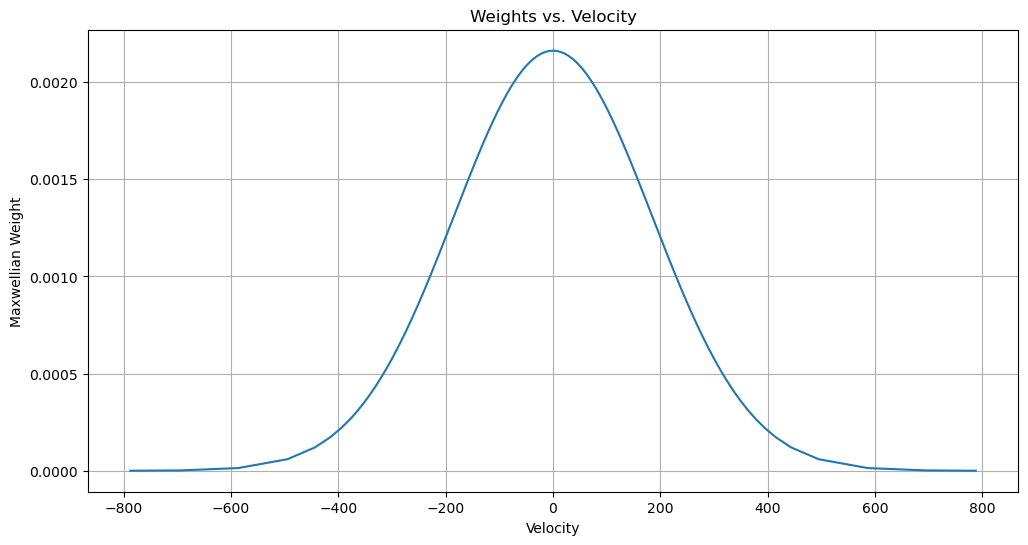

In [3]:
# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))

# Number of velocity points
nv = 251
v_values = np.zeros(nv)
dv = np.zeros(nv)
dv_min = 0.94  # Reduced minimum velocity increment for better resolution

# Middle index (centered at zero velocity)
mid_index = nv // 2
v_values[mid_index] = 0
dv[mid_index] = dv_min * 2

# Area under Maxwellian at zero velocity
area = dv[mid_index] * Maxwellian(0)

# Compute positive velocities
for m in range(mid_index + 1, nv):
    v_end = v_values[m - 1] + dv[m - 1] / 2

    # Define the function to find the root of
    def func(V):
        return Maxwellian((V + v_end) / 2) * (V - v_end) - area

    # Improved initial guess for V
    V_guess = v_end + dv_min

    # Use fsolve to find V such that func(V) = 0
    V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]

    # Update velocity and dv arrays
    v_values[m] = (V_solution + v_end) / 2
    dv[m] = V_solution - v_end

# Reflect to get negative velocities
v_values[:mid_index] = -np.flip(v_values[mid_index + 1:])
dv[:mid_index] = np.flip(dv[mid_index + 1:])

# Maxwell-Boltzmann distribution weights
weights = Maxwellian(v_values)

#print(v_values)
#print(weights)

# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs. Velocity')
plt.xlabel('Velocity')
plt.ylabel('Maxwellian Weight')
plt.grid(True)
plt.show()

## Figure 7a

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 100/400
Processing z step 200/400
Processing z step 300/400
Processing z step 100/400
Processing z step 200/400
Processing z step 300/400
Processing z step 100/400
Processing z step 200/400
Processing z step 300/400


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


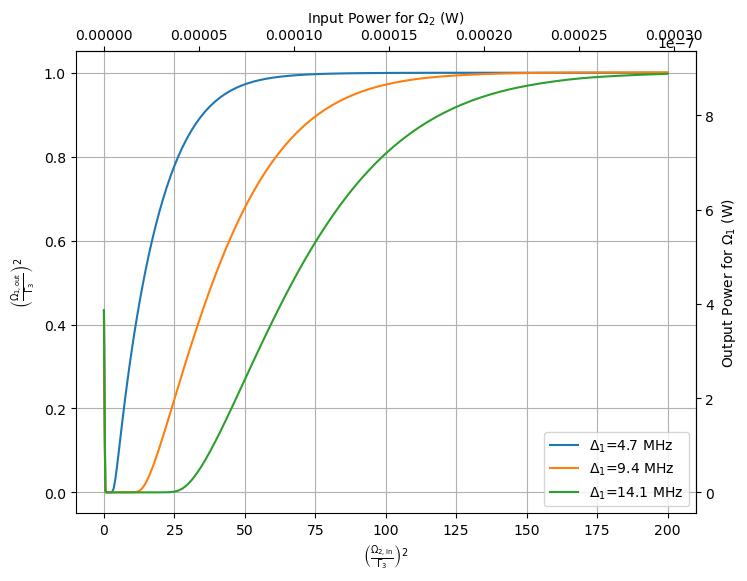

In [7]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 100
    Om_2_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7a.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values\
    Om_1 = np.array([1, 1, 1])*Gamma3
    delta_1 = np.array([1/8, 2/8, 3/8])*Gamma3
    delta_2 = 0*delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## Figure 7b

In [6]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_2_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma_12 = np.array([1/3, 2/3, 1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i]. Gamma_12[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_12$={Gamma_12[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7b.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values\
    Om_1 = np.array([1, 1, 1])*Gamma3
    delta_1 = np.array([2/8, 2/8, 2/8])*Gamma3
    delta_2 = 0*delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

## Figure 7c

In [7]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 100
    Om_1_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7cOnegraph.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([10])*Gamma3
    delta_1 = Om_2/2
    delta_2 = [0]
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 50
    Gamma12 = Gamma21 = 0.015*Gamma3    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/4  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/4  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)
    Om_1_list_adapted = np.linspace(0, np.sqrt(210 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))


def plot_OD(Om_2, delta_1, delta_2):
    # Preallocate output lists
    Output_Omega_1_list = [None] * len(delta_1)
    Output_Omega_2_list = [None] * len(delta_1)

    # Compute outputs for each Δ₁
    for i in range(len(delta_1)):
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = \
            calculate_OD_1(Om_2[i], delta_1[i], delta_2[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])

    # Prepare x‐axis data (same for todas las curvas)
    x_norm2 = (np.real(Om_1_list_adapted))**2 / Gamma3**2
    x_power = x_forward(x_norm2)  # convierte normalizado → potencia (W)

    # Construir DataFrame para Excel
    df = pd.DataFrame({
        'Om1_in_norm2': x_norm2,
        'Input_Power_W': x_power
    })

    for i, d1 in enumerate(delta_1):
        # Normalizado y potencia de salida para cada Δ₁
        y_norm2 = (Output_Omega_1_list[i]**2) / Gamma3**2
        y_power = y_forward(y_norm2)
        df[f'Om1_out_norm2 Δ1={d1:.1f}'] = y_norm2
        df[f'Output_Power_W Δ1={d1:.1f}'] = y_power

    # Determinar ruta y asegurar existencia de directorio
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7c(T=348, Om=10, g12=0.015G, Ziqi,3).pdf"
    out_dir = os.path.dirname(save_path)
    os.makedirs(out_dir, exist_ok=True)

    # Guardar Excel junto a la figura
    excel_path = os.path.join(out_dir, "Figure7c(T=348, Om=10, g12=0.015G, Ziqi,3).xlsx")
    df.to_excel(excel_path, index=False)

    # —– Resto de la función de plotting (igual que antes) —–
    fig, ax1 = plt.subplots(figsize=(8, 6))
    for i, d1 in enumerate(delta_1):
        ax1.plot(
            x_norm2,
            df[f'Om1_out_norm2 Δ1={d1:.1f}'],
            label=f'$\\Delta_1$={d1:.1f} MHz'
        )

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Ejes secundarios para potencia
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')

    # Guardar figura y mostrar
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()



# Widget setup
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',
    tooltip='Click to run the simulation',
    icon='play'
)

def run_simulation(b):
    Om_2 = np.array([10]) * Gamma3
    delta_1 = Om_2 / 2
    delta_2 = [0]
    plot_OD(Om_2, delta_1, delta_2)

run_button.on_click(run_simulation)
display(run_button)


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

## Figure 7d

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999


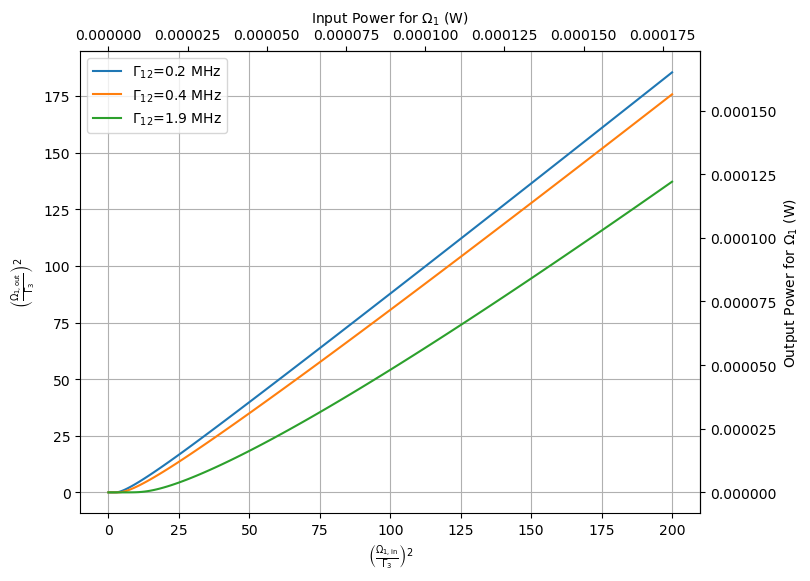

In [20]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_1_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma12 = np.array([0.005, 0.01, 0.05])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i], Gamma12[i])       
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_{{12}}$={Gamma12[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7d.svg"
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1, 1, 1])*Gamma3
    delta_1 = Om_2/2
    delta_2 = [0, 0, 0]
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## Figure 8a

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
X-axis
[0.0, 0.02040608101214162, 0.08162432404856648, 0.1836547291092746, 0.32649729619426593, 0.5101520253035404, 0.7346189164370984, 0.9998979695949392, 1.3059891847770637, 1.6528925619834713, 2.0406081012141617, 2.4691358024691357, 2.9384756657483937, 3.4486276910519345, 3.9995918783797566, 4.591368227731864, 5.223956739108255, 5.897357412508928, 6.611570247933885, 7.366595245383124, 8.162432404856647, 8.999081726354456, 9.876543209876543, 10.794816855422917, 11.753902662993575, 12.75380063258851, 13.794510764207738, 14.87603305785124, 15.998367513519026, 17.161514131211103, 18.365472910927455, 19.6102438526681, 20.89582695643302, 22.22222222222222, 23.58942965003571, 24.997449239873486, 26.44628099173554, 27.93592490562188, 29.466380981532495, 31.037649219467408, 32.64972961942659, 34.30262218141006, 35.996326905417824, 37.73084379144985, 39.50617283950617, 41.32231404958678, 43.17926742169167, 45.07

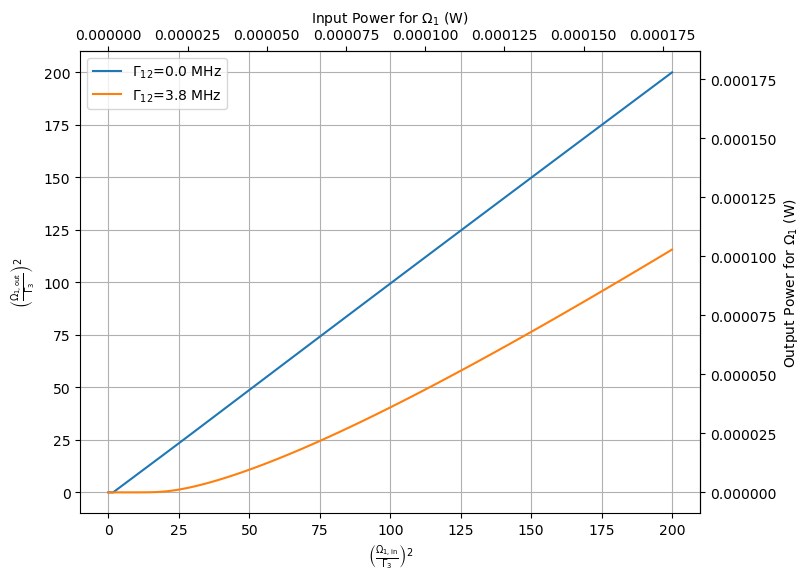

In [12]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_1_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma12 = np.array([0.0, 0.1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i], Gamma12[i])       
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
        print("X-axis")
        print((np.array(np.real(Om_1_list_adapted))**2/Gamma3**2).tolist())
        print("Y-axis")
        print(np.array((Output_Omega_1_list[i])**2/Gamma3**2).tolist())
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_{{12}}$={Gamma12[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_1:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure8a.svg"
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1, 1])*Gamma3
    delta_1 = np.array([2/8, 2/8])*Gamma3
    delta_2 = -delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## Figure 8b

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
X-axis
[0.0, 0.02040608101214162, 0.08162432404856648, 0.1836547291092746, 0.32649729619426593, 0.5101520253035404, 0.7346189164370984, 0.9998979695949392, 1.3059891847770637, 1.6528925619834713, 2.0406081012141617, 2.4691358024691357, 2.9384756657483937, 3.4486276910519345, 3.9995918783797566, 4.591368227731864, 5.223956739108255, 5.897357412508928, 6.611570247933885, 7.366595245383124, 8.162432404856647, 8.999081726354456, 9.876543209876543, 10.794816855422917, 11.753902662993575, 12.75380063258851, 13.794510764207738, 14.87603305785124, 15.998367513519026, 17.161514131211103, 18.365472910927455, 19.6102438526681, 20.89582695643302, 22.22222222222222, 23.58942965003571, 24.997449239873486, 26.44628099173554, 27.93592490562188, 29.466380981532495, 31.037649219467408, 32.64972961942659, 34.30262218141006, 35.996326905417824, 37.73084379144985, 39.50617283950617, 41.32231404958678, 43.17926742169167, 45.07

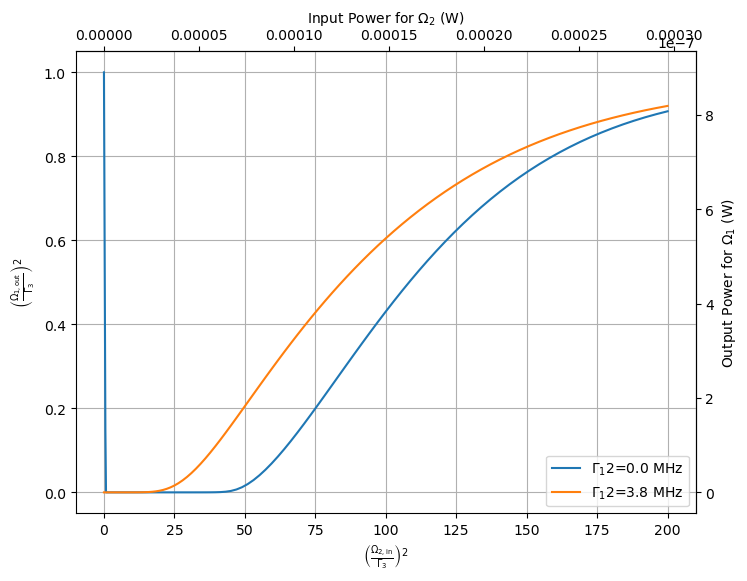

In [14]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_2_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma_12 = np.array([0.0, 0.1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i], Gamma_12[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
        print("X-axis")
        print((np.array(np.real(Om_2_list_adapted))**2/Gamma3**2).tolist())
        print("Y-axis")
        print(np.array((Output_Omega_1_list[i])**2/Gamma3**2).tolist())
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_12$={Gamma_12[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure8b.svg"
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values\
    Om_1 = np.array([1, 1])*Gamma3
    delta_1 = np.array([2/8, 2/8])*Gamma3
    delta_2 = -delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## Figure 8c

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999


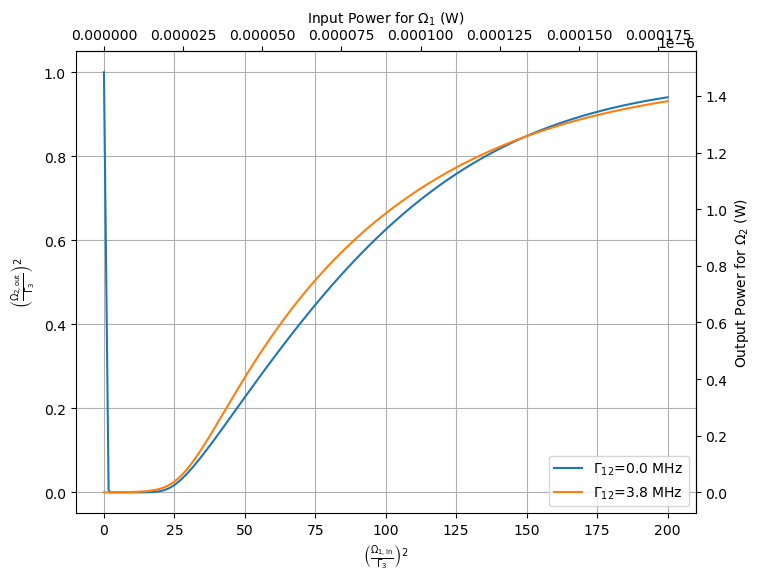

In [15]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_1_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma12 = np.array([0.0, 0.1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i], Gamma12[i])       
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_{{12}}$={Gamma12[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))
    ax_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure8c.svg"
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1, 1])*Gamma3
    delta_1 = np.array([2/8, 2/8])*Gamma3
    delta_2 = -delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

## Figure 8d

In [ ]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_2_list_adapted = np.linspace(0, np.sqrt(200 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma_12 = np.array([0.0, 0.1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i]. Gamma_12[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Gamma_{{12}}$={Gamma_12[i]:.1f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    # or if you want the same function names but with mu_23 inside, define them accordingly.
    ax2_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure8d.svg"
    plt.savefig(save_path, format='svg', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values\
    Om_1 = np.array([1, 1])*Gamma3
    delta_1 = np.array([2/8, 2/8])*Gamma3
    delta_2 = -delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)